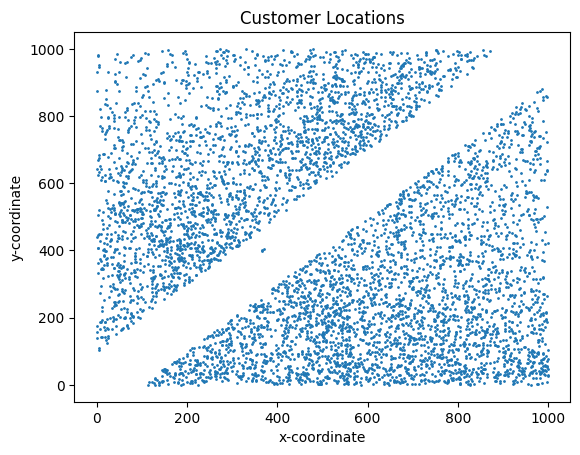

In [273]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/drone_cust_locations.csv', sep=';').drop('clientid', axis=1)

X = df['x']
y = df['y']

plt.scatter(X, y, s=1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Customer Locations')
plt.show()


In [274]:
from sklearn.cluster import KMeans

model = KMeans(init='random', n_clusters=3, random_state=42)
model.fit(df)

model.cluster_centers_

array([[702.08109226, 211.2703835 ],
       [198.44098904, 383.25861847],
       [548.20586479, 787.2788963 ]])

In [275]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

df_with_clusters.head(10)

,x,y,depot
0,622.771572,164.857623,0
1,416.357298,630.193634,2
2,292.735020,567.333231,1
3,737.211288,166.225676,0
4,540.475375,682.912298,2
5,535.469492,318.439661,0
6,640.380050,870.833221,2
7,235.772075,359.048203,1
8,481.896884,661.491838,2
9,730.032789,312.177817,0


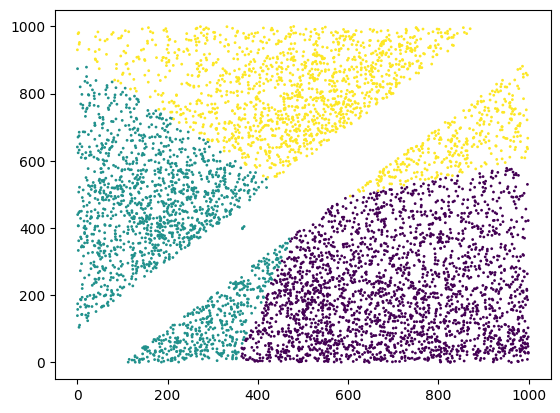

In [276]:
plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

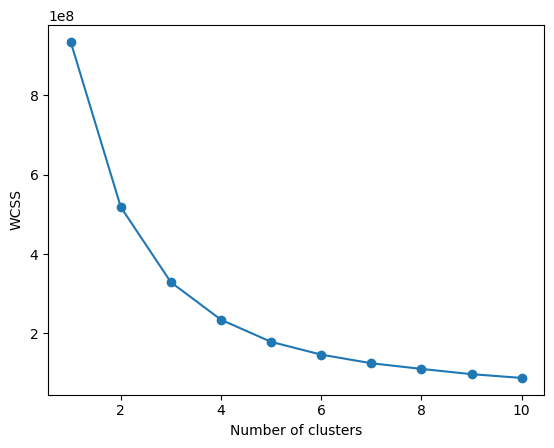

In [277]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df)
    wcss.append(model.inertia_)

plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [278]:
from sklearn.metrics import silhouette_score

model = KMeans(init='random', n_clusters=10, random_state=42)

model.fit(df)
model.cluster_centers_

print(f'Silhouette score: {silhouette_score(df, model.labels_)}')

Silhouette score: 0.36632391559826993


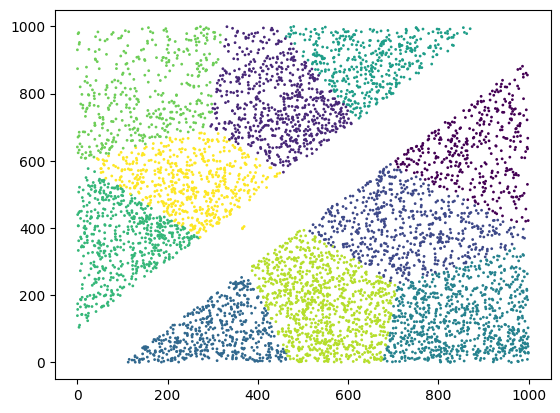

In [279]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

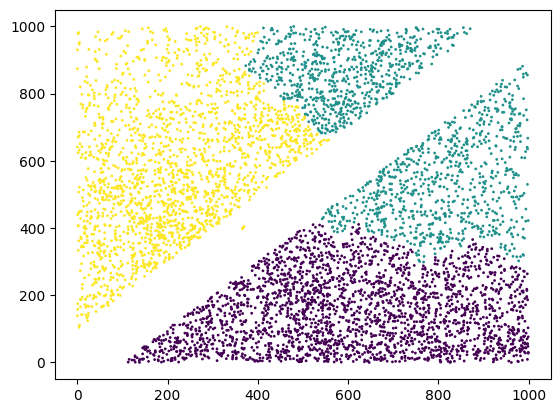

In [280]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3)
clusters = model.fit_predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)